A través del portal de datos abiertos del Ayuntamiento de Madrid, https://datos.madrid.es/portal/site/egob/, pueden obtenerse múltiples conjuntos de datos o *datasets* relativos a actividades de Mercamadrid, tráfico, meteorología, demografía...

También ofrece datos del servicio de alquiler de bicicletas eléctricas del Ayuntamiento de Madrid: *BiciMAD*. Esta práctica consiste en el análisis de estos datos con *Pyspark* para contestar algunas cuestiones interesantes que hemos planteado sobre los mismos. Además, usaremos herramientas tales como como gráficos, mapas, grafos y tablas para visualizar los resultados obtenidos de la mejor manera posible.


Puesto que ya hemos trabajado datasets de *BiciMAD* en clase, no se detallará la estructura de los datos, pues es archiconocida por todos. Si se desease conocer su estructura en detalle el modelo de datos de la información de uso del servicio de *BiciMAD*, puede descargarse el modelo de datos en el siguiente enlace: https://opendata.emtmadrid.es/Documentos/Servicios-y-estructuras-Bicimad-V1-1.aspx. En el documento, se publica la *descripción del modelo de datos utilizado para publicar información relativa a la utilización del servicio de bicicletas eléctricas del Ayuntamiento de Madrid.*
 


**OBJETIVO DE ESTE CUADERNO**

En primer lugar, definamos un período de tiempo de estudio. Vamos a considerar los meses entre Julio de 2018 y Junio de 2019, ambos inclusive, para estudiar un año completo relativamente actual. Esta elección se debe a que son los datos más actualizados en la web https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1).

En estre primer cuaderno, pretendemos analizar la progresión durante el período definido. Estudiaremos el cómputo global de viajes, la variación según el tipo de usuario, código postal y rango de edad. Por último, analizaremos la distribución de viajes para cada hora en cada día de la semana.


# Carga de paquetes necesarios y puesta a punto. 

En primer lugar, cargamos el módulo esencial de la práctica, que servirá para manejar con facilidad las enormes cantidades de datos.
Puesto que no está preinstalado en Python, es necesario instalarlo. 

In [ ]:
!apt-get install openjdk-8-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u252-b09-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


Creamos el SparkContext que utilizaremos a lo largo del cuaderno.

In [ ]:
from pyspark import SparkContext
import json

sc = SparkContext()

Importamos *numpy* y *pandas* para, principalmente, tratar con tablas.

Importamos *matplotlib* para poder crear gráficas.

Importamos *colors* para generar colores para las gráficas.

Importamos *calendar* para tratar con fechas.

Importamos *SparkSession* para tratar con DataFrames.

Importamos *seaborn* para crear hetmaps o mapas de calor.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pylab import *
import calendar
from pyspark.sql import SparkSession
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Carga de datos.

Inicialmente, es necesario acceder a la unidad compartida de drive en la que se almacenan los archivos que se van a utilizar.



Al ejecutar esta celda, se muestra un enlace que permite la vinculación y el acceso al drive. Basta con abirlo, escoger la cuenta con en la que se ha mandado el corrreo que da acceso al drive, y copiar el enlace que aparece. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


Generamos la ruta que nos da acceso.

In [ ]:
path = '/content/drive/Shared drives/Practica BICIMAD-Grupo 5/'

Definimos un *mapper* para quedarnos únicamente con los datos que nos interesan:


*   Código de usuario para un día concreto.
*   Estación de inicio.
*   Edad.
*   Estación de destino.
*   Tiempo de viaje.
*   Tiempo de usuario.
*   Código postal.
*   Fecha.
*   Hora. 





In [ ]:
def mapper(line):
  data = json.loads(line)
  u_c = data['user_day_code']  
  start = data['idunplug_station']
  age = data['ageRange']
  end = data['idplug_station']
  t_t = data ['travel_time']
  u_t = data['user_type']
  z_c = data['zip_code']
  date = data['unplug_hourTime']['$date'][0:10]
  hour = data['unplug_hourTime']['$date'][11:19]
  return u_c, start, end, age, t_t, u_t, z_c, date, hour

Creamos dos rdd's para cada mes entre Julio de 2018 y Junio 2019. que almacenamos en forma de lista, obteniendo así dos listas de listas (posteriormente se tratan como rdd): la primera tiene todos los viajes de cada mes y, en la segunda, eliminamos los viajes fallidos donde consideramos como viajes fallidos aquellos movimientos realizados por los usuarios que sean excesivamente cortos, cuyo  tiempo de uso sea inferior a 30 segundos, y que comiencen y acaben en la misma estación. Ignoramos estos viajes ya que pueden deberse a manipulaciones de las bicicletas por parte de los trabajadores de la empresa o a usuarios que, finalmente, se arrepienten de haber cogido la bicicleta.

In [ ]:
rdd_list_total_trips = []
rdd_list_non_failed_trips = []

for i in range(7,13):
    if len(str(i)) == 1:
        file = '20180' + str(i)  + '_Usage_Bicimad.json'
    else:
        file = '2018' + str(i) + '_Usage_Bicimad.json'
    rdd_month = sc.textFile(path+file)
    rdd_total_trips = rdd_month.map(mapper)
    rdd_filtered_trips = rdd_total_trips.\
        filter(lambda x: x[1] != x[2] and x[4] > 30)
    
    rdd_list_total_trips.append(list(rdd_total_trips.collect()))
    rdd_list_non_failed_trips.append(list(rdd_filtered_trips.collect()))

for i in range(1,7):
    file = '20190' + str(i) +'_Usage_Bicimad.json'
    rdd_month = sc.textFile(path+file)
    rdd_total_trips = rdd_month.map(mapper)
    rdd_filtered_trips = rdd_total_trips.\
        filter(lambda x: x[1] != x[2] and x[4] > 30)
    
    rdd_list_total_trips.append(list(rdd_total_trips.collect()))
    rdd_list_non_failed_trips.append(list(rdd_filtered_trips.collect()))
    

Lista con los meses que estamos considerando.

In [ ]:
months = ['Jul 18','Aug 18','Sept 18','Oct 18','Nov 18','Dec 18','Jan 19',
          'Feb 19','Mar 19','April 19','May 19','June 19']

# Cómputo de viajes



Utilizando las listas calculadas anteriormente, haremos una gráfica para ver el crecimiento o decrecimiento de los viajes totales dependiendo del mes y su comparación con los viajes no fallidos.

In [ ]:
num_trips = []
for rdd in rdd_list_total_trips:
  num_trips.append(sc.parallelize(rdd).count()) #Podría ponerse num_trips.append(len(rdd))

In [ ]:
num_non_failed = []
for rdd in rdd_list_non_failed_trips:
  num_non_failed.append(sc.parallelize(rdd).count())

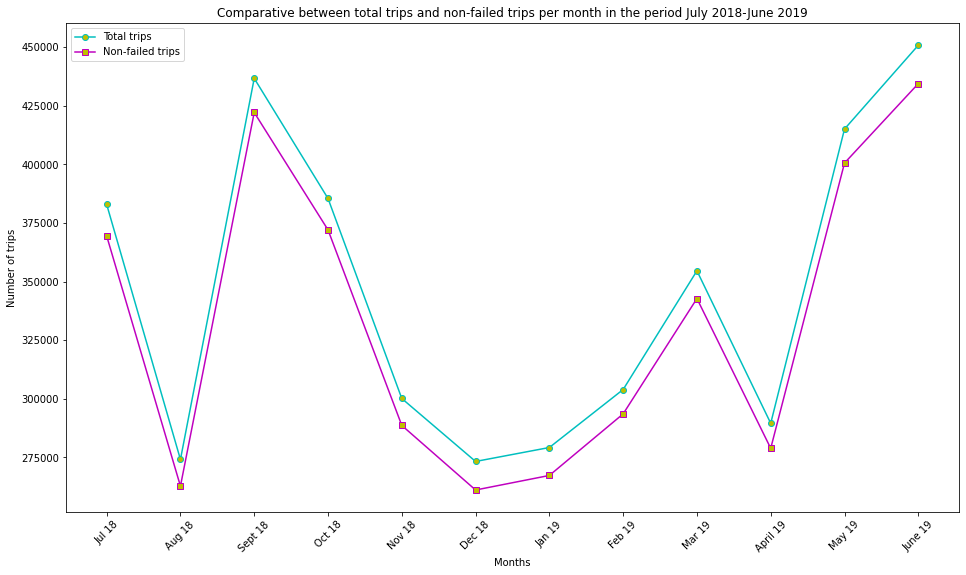

In [ ]:
p1 = plot(months, num_trips,c='c',label='Total trips',mfc='y',ls='-',marker='o')
p2 = plot(months, num_non_failed,c='m',label='Non-failed trips',mfc='y',ls='-',marker='s')
xlabel("Months")
ylabel("Number of trips")
legend(loc='best')
title('Comparative between total trips and non-failed trips per month in the period July 2018-June 2019')
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = [16,9] #Ejecutar dos veces para obtener este tamaño
show()


En la gráfica, podemos observar que el mes con menos viajes (tanto totales como los no fallidos) es el mes de Diciembre de 2018 y que el mes con más viajes (tanto totales como no fallidos) es Junio de 2019.



A continuación, manipularemos los datos obtenidos para obtener una tabla en la que puedan visualizarse los valores obtenidos en la gráfica junnto a más información.


Analizamos cuál es la pérdida de viajes entre los totales y los filtrados. Saldrá en términos negativos, pues si hubo, por ejemplo, 10 viajes totales y, tras filtrarlos, 7, aparecerá -3.

In [ ]:
num_dif_NonFailed_Failed = [x1 - x2 for (x1, x2) in zip(num_non_failed, num_trips)]

Calculamos el pocentaje de viajes no fallidos.

In [ ]:
non_failed_perc = [x1 / x2 * 100  for (x1, x2) in zip(num_non_failed, num_trips)]

Calculamos el porcentaje de viajes fallidos.

In [ ]:
failed_perc = [(x2-x1) / x2 * 100  for (x1, x2) in zip(num_non_failed, num_trips)]

Generamos la tabla.

In [ ]:
data_trips = {'Months' : months, 'Total trips' : num_trips, 'Non failed trips': num_non_failed, 'Difference non failed-failed': num_dif_NonFailed_Failed, 'Non-failed trips percentage': non_failed_perc, 'Failed trips percentage': failed_perc}
tabla_trips = pd.DataFrame(data_trips)
tabla_trips

,Months,Total trips,Non failed trips,Difference non failed-failed,Non-failed trips percentage,Failed trips percentage
0,Jul 18,382929,369494,-13435,96.491517,3.508483
1,Aug 18,274122,262754,-11368,95.852941,4.147059
2,Sept 18,436681,422126,-14555,96.666903,3.333097
3,Oct 18,385450,372052,-13398,96.524063,3.475937
4,Nov 18,300131,288642,-11489,96.172005,3.827995
5,Dec 18,273272,261096,-12176,95.544366,4.455634
6,Jan 19,279223,267303,-11920,95.731011,4.268989
7,Feb 19,303962,293562,-10400,96.578520,3.421480
8,Mar 19,354597,342766,-11831,96.663536,3.336464
9,April 19,289554,278877,-10677,96.312605,3.687395


En la presente tabla, podemos observar el número de viajes totales y viajes filtrados.

Obsevamos que el mes el que se produjeron más viajes es Junio de 2019 y el mes en el que menos viajes hubo fue Diciembre de 2018 (tanto totales como filtrados)

Además, se comprueba la diferencia entre viajes totales y no fallidos se mantiene estable a lo largo de todos los meses, pues, aunque el cómputo total varíe entre los 10400 viajes de Febrero de 2019 hasta los 16370 de Junio de 2019, en términos porcentuales, se mueve entre el 3,3330967% y el 4,455633947%.



#Análisis del tipo de usuarios

En este apartado analizamos la variación del tipo de usuario del servicio a lo largo del periodo anteriormente indicado.
*BiciMAD* registra, en cada viaje que se realiza, el apartado *‘Usertype’* que contendrá  uno de los siguientes números:
      
*   0: En caso de que no se haya podido determinar el tipo de usuario
*   1: El usuario posee un abono anual
*   2: Usuario ocasional
*   3: Trabajador de la empresa


Para visualizar mejor los datos, definimos la función survey, que nos permitirá mostrar los resultados mediante un gráfico de barras horizontales apiladas.

In [ ]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('pink')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height= 0.7,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color 
        text_color = 'black' if r * g * b < 0.5 else 'blue'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(round(c,3)), fontsize=8, ha='left', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=10)

    return fig, ax
 

En primer lugar, estudiamos los **tipos de usuario en los viajes totales** sin tener en cuenta el filtrado en el que se descartaban viajes de menos de treinta segundos cuya estación de destino y final coincidiesen. 

Para almacenar los datos, para cada mes, crearemos un diccionario en el que las claves serán 0,1,2,3, es decir, los tipos de usuario, y los valores serán, bien el porcentaje (se almacenarán en *list_dicts_total_percentage*) o bien el número acumulado (se almacenarán en *list_dic_total*).

Para ello, entramos en un bucle en el que se consideran los elementos de *rdd_list_total_trips* con la función ennumerate, que nos servirá para, a la hora de calcular el porcentaje, remitirnos al mes adecuado, cuyos viajes acumulados han sido hallados en la sección anterior. A continuación, se paraleliza la lista para convertirla en rdd y nos quedamos con el elemento en la posión 5, que es el tipo de usuario. Hacemos un countByValue() para ver cuántos hay. Posteriormente se crean los diccionarios.

En ocasiones, hemos comprobado que el usuario tipo 0 no queda registrado y, tal y como está planteada la gráfica lo necesitamos, de ahí el condicional.

In [ ]:
list_dicts_total_percentage = []
list_dicts_total = []

for rdd in enumerate(rdd_list_total_trips):
    rdd_user_type_total_trips = sc.parallelize(rdd[1]).map(lambda x: x[5])
    dict_total = rdd_user_type_total_trips.countByValue()
    dict_total_percentage = {}
    if 0 not in dict_total:
      dict_total[0] = 0
    for k,v in dict_total.items():
      pct = v*100/num_trips[rdd[0]]
      dict_total_percentage[k] = pct
    list_dicts_total_percentage.append(dict(sorted(dict_total_percentage.items())))
    list_dicts_total.append(dict(sorted(dict_total.items())))

Se muestra el **porcentaje de tipo de usuario según el mes para el total de viajes sin filtrar.**

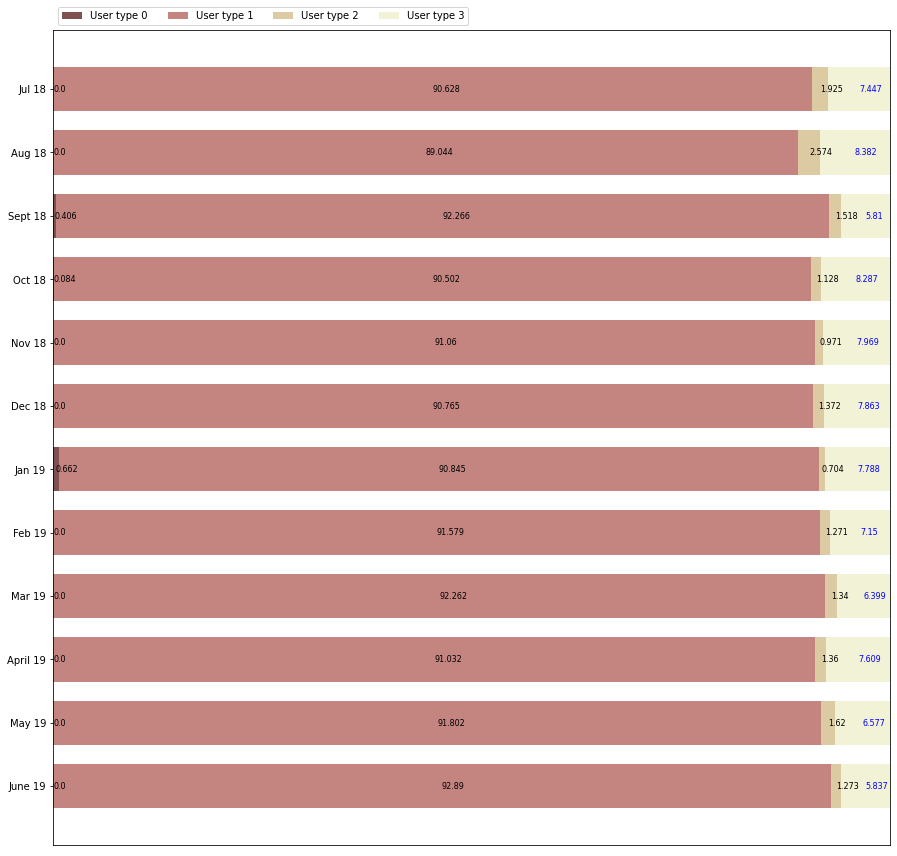

In [ ]:
category_names = ['User type 0', 'User type 1', 'User type 2', 'User type 3']
results = {}
for i in range(0,len(months)):
    results[months[i]] = list(list_dicts_total_percentage[i].values())

survey(results, category_names)
plt.show()

En esta primera gráfica vemos, mes a mes, el porcentaje de usuarios de cada tipo para los viajes totales (sin filtrar). Podemos observar que en todos los meses se mantiene el tipo 1 de usuario como predominante, aproximadamente el  90% de usuarios que utilizan mensualmente el servicio poseen un abono anual. Exceptuando el mes de Agosto en el que sube ligeramente el porcentaje de usuarios ocasionales, en el resto de meses este porcentaje no alcanza el 2%.

Por lo tanto, deducimos que la época del año no influye significativamente en el tipo de usuario que utiliza el servicio: los porcentajes no varían más de tres puntos entre ninguno de los meses.


Ahora mostraremos el **total de usuarios por tipo según el mes para el total de viajes sin filtrar.**

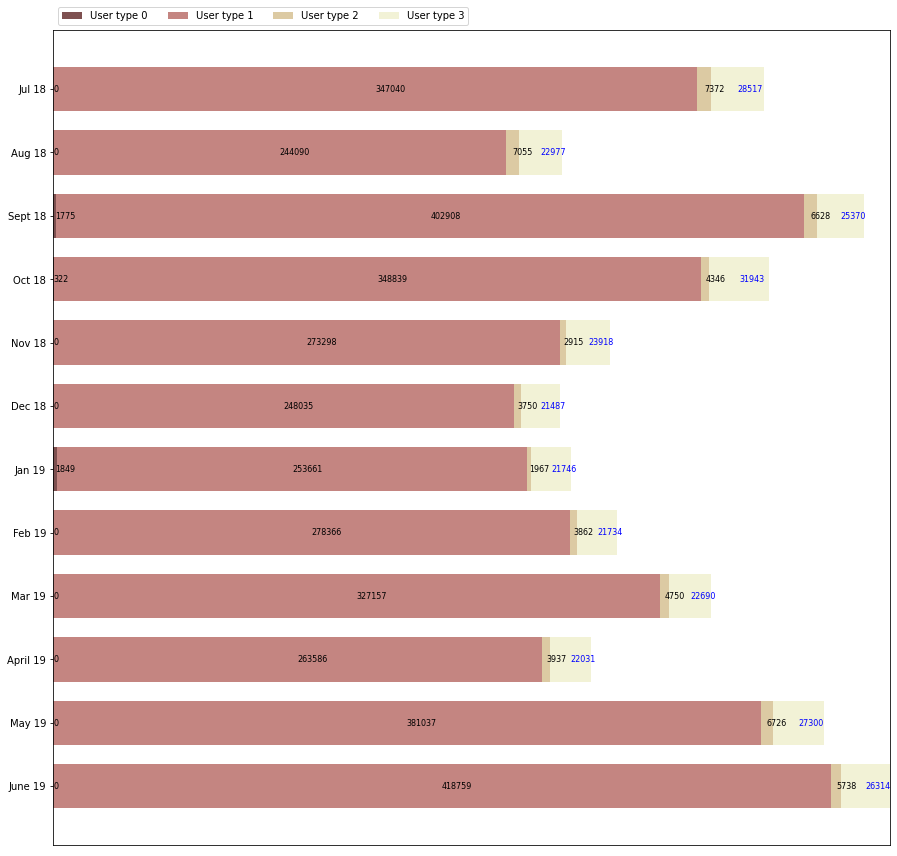

In [ ]:
category_names = ['User type 0', 'User type 1', 'User type 2', 'User type 3']
results = {}
for i in range(0,len(months)):
    results[months[i]] = list(list_dicts_total[i].values())

survey(results, category_names)
plt.show()

Puede comprobarse que el total de usuarios coincide con el total de viajes.

En este gráfico podemos ver que, aunque a lo largo del año, los porcentajes según el tipo de usuarios se mantiene constante, la cantidad de viajes si varía significativamente según la época del año.

Vamos a repetir el **mismo análisis**, esta vez **utilizando los datos filtrados** según los criterios expuestos en el apartado ‘Cómputo de Viajes’.

In [ ]:
list_dicts_non_failed_percentage = []
list_dicts_non_failed = []

for rdd in enumerate(rdd_list_non_failed_trips):
    rdd_user_type_non_failed_trips = sc.parallelize(rdd[1]).map(lambda x: x[5])
    dict_non_failed = rdd_user_type_non_failed_trips.countByValue()
    dict_non_failed_percentage = {}
    if 0 not in dict_non_failed:
      dict_non_failed[0] = 0
    for k,v in dict_non_failed.items():
      pct = v*100/num_non_failed[rdd[0]]
      dict_non_failed_percentage[k] = pct
    list_dicts_non_failed_percentage.append(dict(sorted(dict_non_failed_percentage.items())))
    list_dicts_non_failed.append(dict(sorted(dict_non_failed.items())))

Se muestra el **porcentaje de tipo de usuario** según el mes para el total de viajes filtrados.

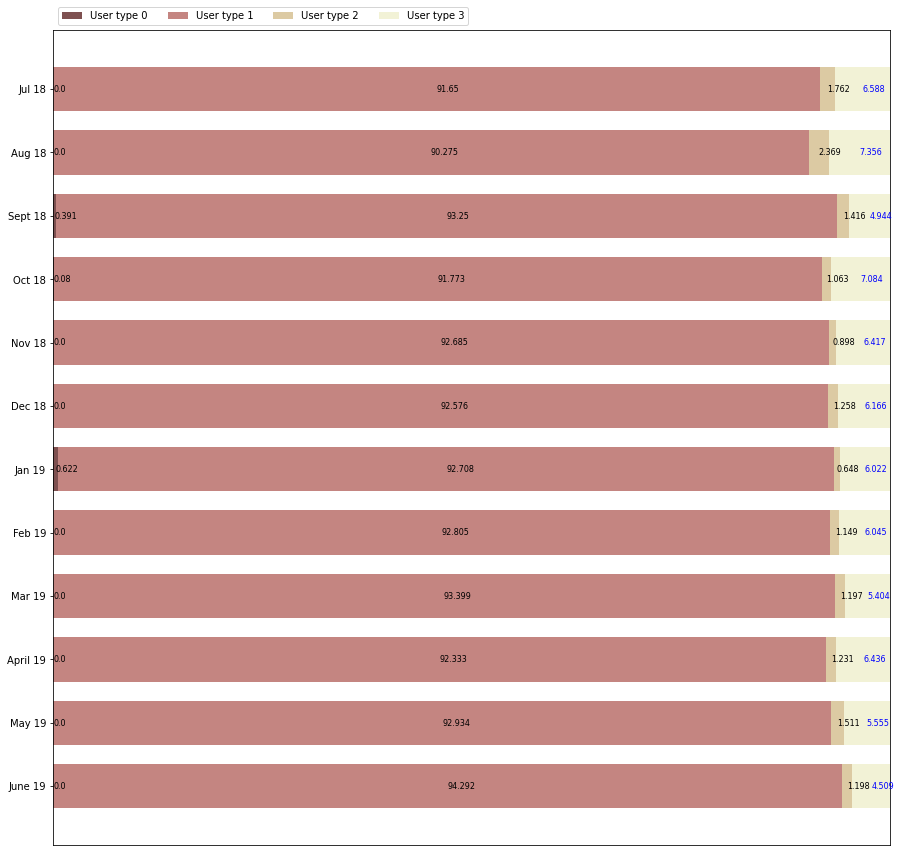

In [ ]:
category_names = ['User type 0', 'User type 1', 'User type 2', 'User type 3']
results = {}
for i in range(0,len(months)):
    results[months[i]] = list(list_dicts_non_failed_percentage[i].values())

survey(results, category_names)
plt.show()

Podemos observar que los resultados obtenidos al quitar los viajes ‘fallidos’ son similares. Al quitar estos viajes, en todos los meses más del 90% de usuarios del servicio poseen un abono anual, y de nuevo el porcentaje de usuarios que hace un uso ocasional del servicio ronda el 1-2%, alcanzando su máximo en agosto, único mes del año en el que  este porcentaje supera el 2%.

Se muestra el **total de usuarios por tipo** según el mes para el total de viajes filtrados.

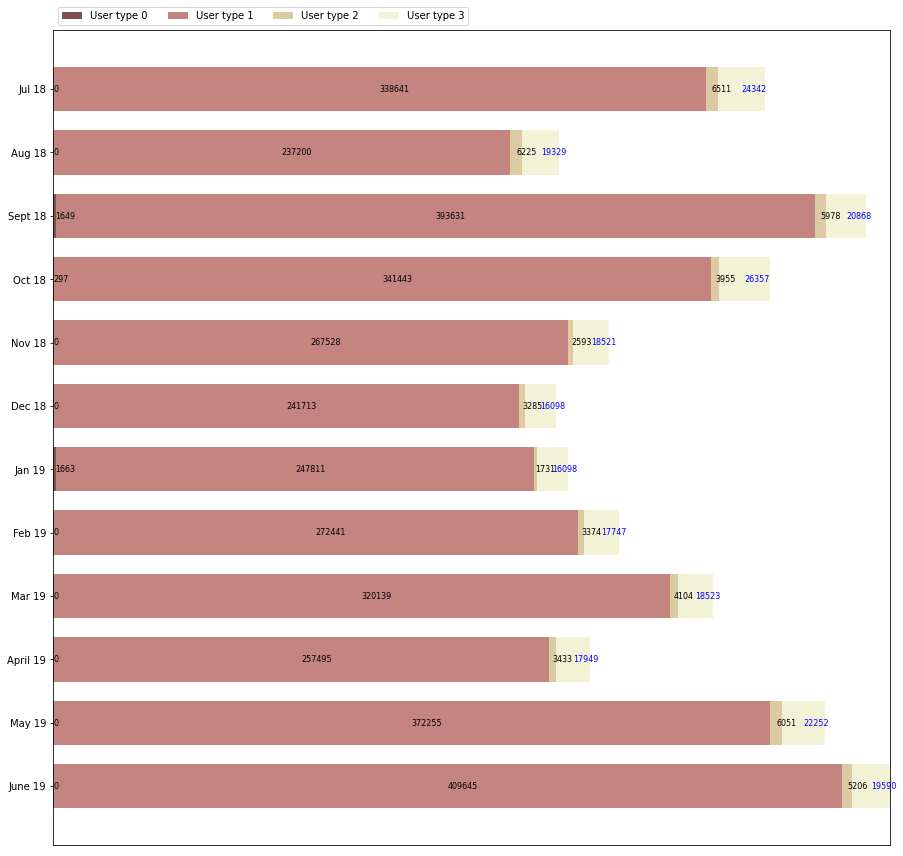

In [ ]:
category_names = ['User type 0', 'User type 1', 'User type 2', 'User type 3']
result = {}
for i in range(0,len(months)):
    results[months[i]] = list(list_dicts_non_failed[i].values())

survey(results, category_names)
plt.show()

 De nuevo, se mantiene la tendencia anterior: el tipo de usuario, no cambia significativamente según la época del año, sin embargo la cantidad de viajes si que es significativamente superior en los meses cálidos, que en los meses demasiado fríos o demasiado calurosos.


#Usuarios según código postal (zip_code)

**En lo que sigue, tratamos con los viajes filtrados.**

Queremos ver ahora de dónde son los usuarios de *BiciMAD*, para ello vamos a diferenciar entre los que no nos proporcionan su código postal, los que son de la ciudad de Madrid, los que son de la Comunidad de Madrid pero no de Madrid capital, y los que no cumplen ninguna de las anteriores (que son de otra Comunidad Autónoma).

Diferenciamos los códigos postales de la ciudad de Madrid, comprendidos entre el 28000 y el 28055, los de la Comunidad Autónoma de Madrid exluyendo Madrid capital, entre el 28056 y el 29000 (en realidad no hay tantos códigos postales como numeros en ese rango, pero todos los códigos postales están compredidos en ese tramo).

Tenemos en cuenta que en los archivos .json se almacenen como string y no como int.

In [ ]:
zc_CM = list(map(str, list(range(28000, 29000))))

In [ ]:
non_zc = []
number_CM = []
number_M = []
number_other = []
for rdd in enumerate(rdd_list_non_failed_trips):
  non_failed_z_c = sc.parallelize(rdd[1]).map(lambda x: (x[6],tuple(x[0:6])))
  non_failed_z_c_F = non_failed_z_c.filter(lambda x: x[0]!='')
  n_zc=non_failed_z_c.count()-non_failed_z_c_F.count()
  
  non_zc.append(n_zc)

  number_CM.append(non_failed_z_c_F.filter(lambda x: x[0] in zc_CM[56:]).count())

  number_M.append(non_failed_z_c_F.filter(lambda x: x[0] in zc_CM[0:56]).count())
    
  number_other.append(non_failed_z_c_F.filter(lambda x: x[0] not in zc_CM).count())


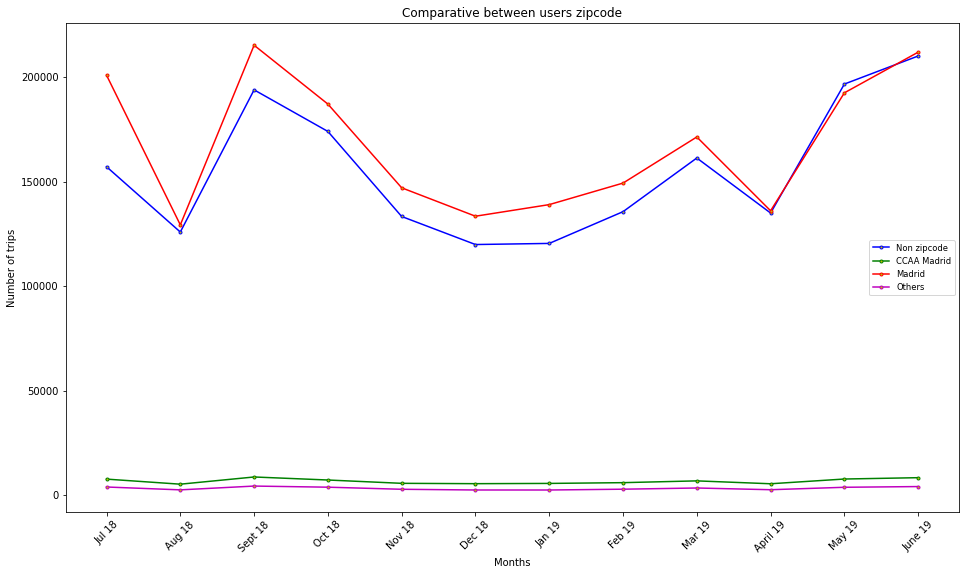

In [ ]:
p1 = plot(months, non_zc,c='b',label='Non zipcode',mfc='y',ls='-',marker='.')
p2 = plot(months, number_CM,c='g',label='CCAA Madrid',mfc='y',ls='-',marker='.')
p3 = plot(months, number_M,c='r',label='Madrid',mfc='y',ls='-',marker='.')
p4 = plot(months, number_other,c='m',label='Others',mfc='y',ls='-',marker='.')
xlabel("Months")
ylabel("Number of trips")
legend(loc='best', fontsize = 'small')
title('Comparative between users zipcode')
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = [16,9]
show()

In [ ]:
num_non_zp_perc = [x1/x2*100 for (x1,x2) in zip(non_zc,num_non_failed)]

In [ ]:
num_CM_perc = [x1/x2*100 for (x1,x2) in zip(number_CM,num_non_failed)]

In [ ]:
num_M_perc = [x1/x2*100 for (x1,x2) in zip(number_M,num_non_failed)]

In [ ]:
num_other_perc = [x1/x2*100 for (x1,x2) in zip(number_other,num_non_failed)]

In [ ]:
data_zc = {'Months' : months, 'Non failed trips': num_non_failed, 'Non zipcode percentage': num_non_zp_perc, 'CCAA Madrid percentaje': num_CM_perc, 'Madrid percentaje': num_M_perc, 'Others percentaje': num_other_perc}
tabla_zc = pd.DataFrame(data_zc)
tabla_zc

,Months,Non failed trips,Non zipcode percentage,CCAA Madrid percentaje,Madrid percentaje,Others percentaje
0,Jul 18,369494,42.531949,2.047936,54.394388,1.025727
1,Aug 18,262754,47.910213,1.955822,49.212952,0.921014
2,Sept 18,422126,45.950261,2.034701,51.011073,1.003966
3,Oct 18,372052,46.782170,1.918818,50.303990,0.995022
4,Nov 18,288642,46.191476,1.922797,50.950312,0.935415
5,Dec 18,261096,45.921424,2.061694,51.114150,0.902733
6,Jan 19,267303,45.054489,2.059461,52.005776,0.880274
7,Feb 19,293562,46.202846,1.998896,50.865235,0.933023
8,Mar 19,342766,47.067095,1.961396,50.005543,0.965965
9,April 19,278877,48.402701,1.915181,48.789968,0.892150


En la gráfica podemos observar que aunque hay bastantes datos de los cuales no conocemos su zip_code, estos siempre son menores que el número de viajes que hay de la ciudad de Madrid(podemos verlo también en la tabla con los porcentajes de datos)
Podemos observar además que la mayoría de viajes que se realizan es por usuarios de Madrid, es decir, hay muy pocos usuarios de otras localidades de la Comunidad de Madrid que usen este servicio.
Por otro lado, podemos ver que el número de viajes realizados por usuarios de otras comunidades es muy bajo, esto se debe a que los usuarios que viven fuera de la Comunidad de Madrid usarán este servicio de forma muy ocasional.



# Usuarios según el rango de edad

Bicimad nos proporciona alguna información sobre la edad de sus usuarios. El campo de información 'Age Range' puede tomar los siguientes valores:
* 0 :cuando no puede determinarse la edad del usuario.
* 1 : 0-16 años
* 2 : 17-18 años
* 3 : 19-26 años
* 4 : 27-40 años
* 5 : 41-65 años
* 6 : 66 años o más

Queremos conocer que franja de edad es la que más utiliza el servicio, y si existe alguna diferencia significativa entre los usuarios del servicio en función de la época del año.


In [ ]:
t0=[]
t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
for rdd in enumerate(rdd_list_non_failed_trips):
  rdd_Age_Range = sc.parallelize(rdd[1]).map(lambda x: (x[3],x[0])).countByKey()
  rdd_sorted = sorted(rdd_Age_Range.items())
  
  t0.append(rdd_sorted[0][1])
  t1.append(rdd_sorted[1][1])
  t2.append(rdd_sorted[2][1])
  t3.append(rdd_sorted[3][1])
  t4.append(rdd_sorted[4][1])
  t5.append(rdd_sorted[5][1])
  t6.append(rdd_sorted[6][1])


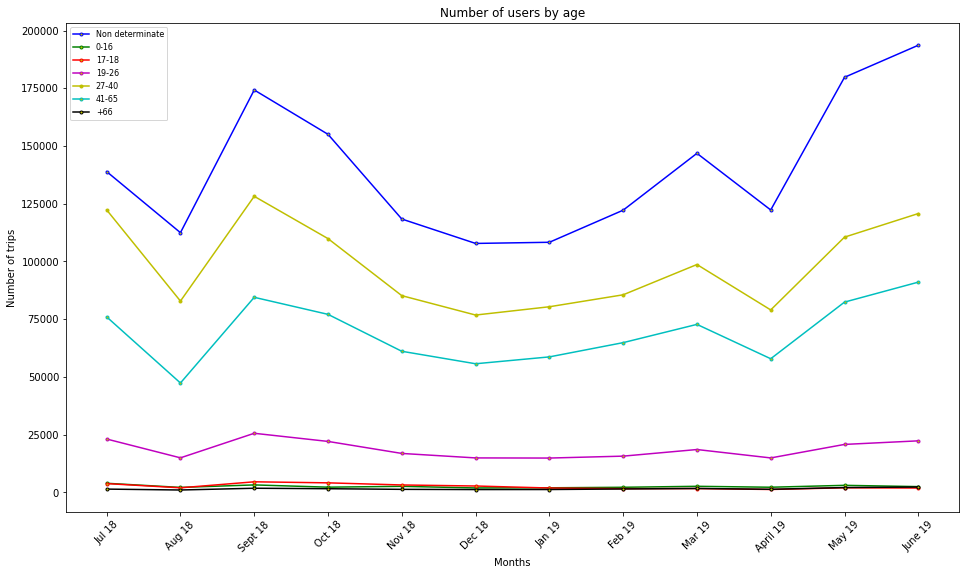

In [ ]:
a0 = plot(months, t0,c='b',label='Non determinate',mfc='y',ls='-',marker='.')
a1 = plot(months, t1,c='g',label='0-16',mfc='y',ls='-',marker='.')
a2 = plot(months, t2,c='r',label='17-18',mfc='y',ls='-',marker='.')
a3 = plot(months, t3,c='m',label='19-26',mfc='y',ls='-',marker='.')
a4 = plot(months, t4,c='y',label='27-40',mfc='y',ls='-',marker='.')
a5 = plot(months, t5,c='c',label='41-65',mfc='y',ls='-',marker='.')
a6 = plot(months, t6,c='k',label='+66',mfc='y',ls='-',marker='.')



xlabel("Months")
ylabel("Number of trips")
legend(loc='best', fontsize=8)
title('Number of users by age')
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = [16,9]
show()

In [ ]:
non_det_perc = [x1/x2*100 for (x1,x2) in zip(t0,num_non_failed)]

In [ ]:
t1_perc = [x1/x2*100 for (x1,x2) in zip(t1,num_non_failed)]

In [ ]:
t2_perc = [x1/x2*100 for (x1,x2) in zip(t2,num_non_failed)]

In [ ]:
t3_perc = [x1/x2*100 for (x1,x2) in zip(t3,num_non_failed)]

In [ ]:
t4_perc = [x1/x2*100 for (x1,x2) in zip(t4,num_non_failed)]

In [ ]:
t5_perc = [x1/x2*100 for (x1,x2) in zip(t5,num_non_failed)]

In [ ]:
t6_perc = [x1/x2*100 for (x1,x2) in zip(t6,num_non_failed)]

In [ ]:
data_age = {'Months' : months, 'Non failed trips': num_non_failed, 'Non determitate percentage': non_det_perc, '0-16 age percentage': t1_perc, '17-18 age percentage': t2_perc, '19-26 age percentage': t3_perc, '27-40 age percentage': t4_perc, '41-65 age percentage': t5_perc, '66+ age percentage': t6_perc}
tabla_age = pd.DataFrame(data_age)
tabla_age

,Months,Non failed trips,Non determitate percentage,0-16 age percentage,17-18 age percentage,19-26 age percentage,27-40 age percentage,41-65 age percentage,66+ age percentage
0,Jul 18,369494,37.598445,1.064158,1.027892,6.250981,33.108251,20.568128,0.382144
1,Aug 18,262754,42.802393,0.814831,0.750131,5.690113,31.529111,18.024845,0.388576
2,Sept 18,422126,41.283645,0.763990,1.082615,6.060987,30.374580,20.011561,0.422623
3,Oct 18,372052,41.677507,0.603679,1.107372,5.929279,29.537269,20.720222,0.424672
4,Nov 18,288642,41.011703,0.904927,1.109333,5.840453,29.514069,21.168091,0.451424
5,Dec 18,261096,41.290943,0.733064,1.054018,5.713224,29.411787,21.331617,0.465346
6,Jan 19,267303,40.518438,0.739984,0.703696,5.558112,30.072240,21.948126,0.459404
7,Feb 19,293562,41.629366,0.749416,0.544008,5.343675,29.145462,22.088009,0.500065
8,Mar 19,342766,42.837679,0.765245,0.477294,5.411855,28.788153,21.224392,0.495382
9,April 19,278877,43.853383,0.795691,0.446433,5.347160,28.329335,20.751801,0.476196


Por la gráfica y la tabla podemos observar lo siguiente: 


*   Cada mes, entre el 37% y el 45% de los datos no disponen de información en el campo AgeRange.
*   La gran mayoría de usuarios, tiene entre 27 y 40 años (en torno a un 30%) seguido de los usuarios de entre 41- y 65 años (en torno a un 20%) 
*   Esta tendencia se mantiene a lo largo de todo el año.

Por lo tanto, no podemos concluir que ningún mes del año nos aporte más infomación sobre la edad de los usuarios.









# Análisis de la distribución de los viajes en función de la hora y el día de la semana

Para desarrollar este apartado, hemos seleccionado, de entre todos los meses que teníamos al principio, el mejor y el peor; entendiendo por mejor mes aquel en el que más viajes se realizan y peor, en el que menos. Nos centramos en el análisis de estos dos meses.

Hemos observado que en el dataset del peor mes, Diciembre de 2018, aparecen también datos relativos al 1 de enero de 2019 a las 00:00. Hemos decidido dejarlos, pues sólo suman y, en cualquier caso, seguirá siendo el peor mes. En el dataset del mejor mes, tan sólo se registran viajes hasta el 26 de junio, por ello, seguiría siendo el mejor mes aunque se sumasen el resto de viajes de ese mes. Desconocemos a qué se debe este desajuste en los datasets, pero hemos decidido tratarlos tal y como son ofrecidos por parte del portal de datos abierto de la Comunidad de Madrid. 

Para seleccionar los meses, en lugar de mirar directamente la gráfica, pues podría generar cierta confusión, especialmente a la hora de hallar el peor mes, nos ayudamos del comando *.index*. Leemos las rdds correspondientes al peor y mejor mes (*rdd_w* y *rdd_b* respectivamente), con las que trabajeremos en lo que sigue. 

In [ ]:
worst_month_index = num_non_failed.index(min(num_non_failed))
best_month_index = num_non_failed.index(max(num_non_failed))
worst_month = months[worst_month_index]
best_month = months[best_month_index]
num_trips_w = num_non_failed[worst_month_index]
num_trips_b = num_non_failed[best_month_index]
rdd_w = sc.parallelize(rdd_list_non_failed_trips[worst_month_index])
rdd_b = sc.parallelize(rdd_list_non_failed_trips[best_month_index])

Creamos una función que, dada una fehca en dormato ISO 8610, devuelve el día de la semana correspondiente (lunes, martes,...)

In [ ]:
def convert_day_week(date):
    """
    Parameters: str
    Represents a date year-month-day
    Return: str
    The weekday of the date
    """
    weekdays = list(calendar.day_name)
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:10])
    num = datetime.date(year, month, day).isocalendar()[2]
    return str(num) + '.' + weekdays[num-1]

El primer estudio que vamos a hacer sobre el "peor" y el "mejor" mes, es en relación a la distribución de los trayectos durante estos dos meses: buscamos conocer los días de la semana en los que más trayectos se producen y las  horas de mayor uso del servicio. Para visualizar mejor esta información, vamos a elaborar para los meses de Diciembre 2018 (mes con menos viajes) y Junio 2019 (mes con más viajes) unos mapas de calor, que contendrán la siguiente información:

-En el eje horizontal, los días de la semana.

-En el eje vertical, las horas del día, en intervalos de una hora.

-Cada recuadro, contiene la media de viajes que se ha producido ese mes para cada día de la semana y cada hora.

Debemos tener en cuenta lo siguiente: para preservar la privacidad de sus usuarios, Bicimad no recoge la hora exacta de cada trayecto. Por ejemplo, si un usuario recoge una bici a las 15:43:12, la hora de inicio que aparecerá recogida en el dataset de Bicimad es las 15:00:00. La celdas de la fila correspondiente a la hora 15:00:00 recoge los viajes entre las 15:00:00 y las 15:59:59


Lo primero que vamos a hacer es reestructurar los datos para que la información esté organizada de manera más manipulable y útil para nuestro fin.

Para cada trayecto nos interesa la fecha y la hora a la que se produjo: utilizamos la función map para obtener una tupla de la forma ('dia'+' '+hora, 1) para cada trayecto.
Agrupamos los trayectos según la clave, y almacenamos los valores correspondientes a cada una en una lista.
A continuación, sumamos los valores de las claves para obtener el número de viajes de esa hora y ese día concreto.
Para cada día del mes, nos interesa saber qué día de la semana fue. Para ello, utilizamos la función *convert_day_week*.
Por último volvemos a agrupar los datos según su clave (día de la semana,hora del día) y valor (número de trayectos correspondientes a ese día y hora) y se calcula la media de viajes para cada día y hora concreto.


In [ ]:
rdd_mean1 = rdd_w.map(lambda x: (x[7]+' '+x[8], 1)).\
            groupByKey().mapValues(list).\
            mapValues(lambda x: sum(x)).\
            map(lambda x: (convert_day_week(x[0][0:10])+x[0][10:], x[1])).\
            groupByKey().mapValues(list).\
            mapValues(lambda x: sum(x) / len(x))


Como paso intermedio, convertimos la rdd es un DataFrame separando la fecha, la hora, y la media de viajes realizadas en cada día de la semana y en cada hora durante en mes. Lo almacenamos en tres apartados: 'Weekday', 'Hour', 'Trips Average'.

In [ ]:
spark = SparkSession.builder.getOrCreate()
df_w = spark.createDataFrame(rdd_mean1.map(lambda x: (x[0].split()[0],x[0].split()[1],float(x[1]))), schema = ['Weekday', 'Hour', 'Trips Average'])

Lo convertimos en un objeto panda para poder manejarlo mejor a la hora de crear el heatmap.

In [ ]:
panda_w = df_w.toPandas()

Para crear el hetmap, tomamos como valores la columna 'Trips Average' del objeto panda, y empleamos como índice 'Hour' y como columna 'Weekday'.

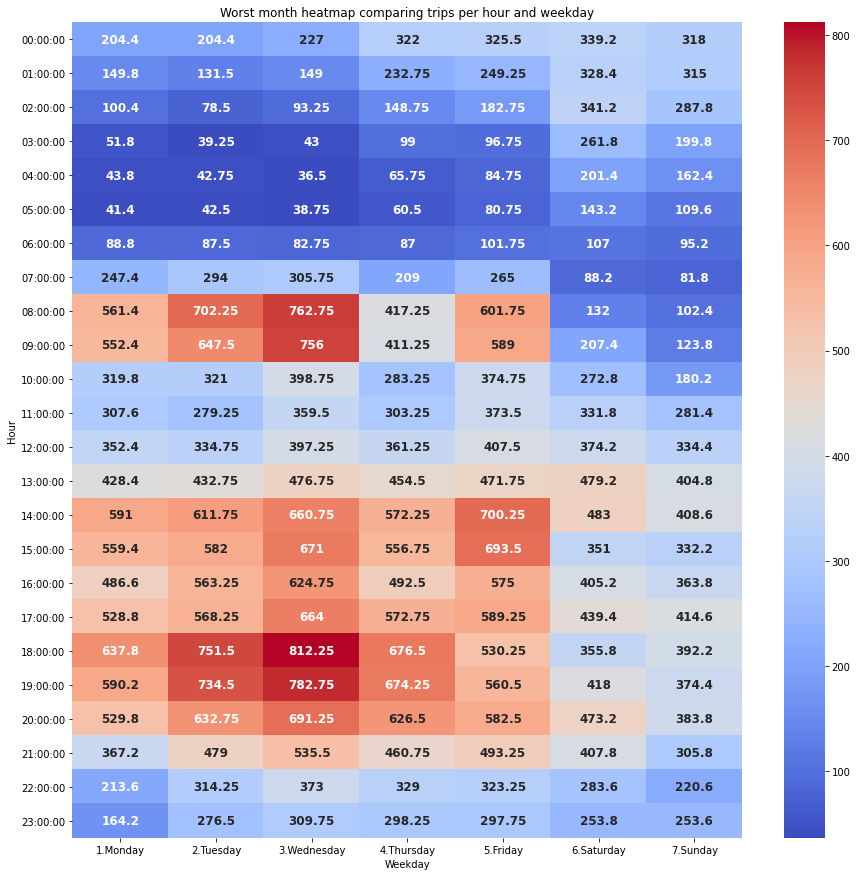

In [ ]:
plt.figure(figsize=(15,15))
heatmap_trips_w = pd.pivot_table(panda_w, values = 'Trips Average', index=['Hour'], columns='Weekday')
sns.heatmap(heatmap_trips_w, cmap='coolwarm', annot=True, fmt='g',  annot_kws={"fontsize":12, 'weight':'bold'})
plt.title("Worst month heatmap comparing trips per hour and weekday")
show()

En esta primera gráfica, podemos ver la información sobre la distribución de los viajes relativa al peor mes. 

Podemos observar algunas tendencias: entre semana, las franjas horarias en las que se produce un mayor uso del servicio son, por las mañanas de 8:00 a 9:59 y por las tardes de 14:00 a 21:59.

Durante el fin de semana, el uso de las bicis cae en casi todas las franjas horarias, excepto entre las 00:00 y las 06:59 de la madrugada: en esta franja, podemos observar como el número de viajes realizados en sábado y domingo es notablemente superior al número de viajes de lunes a viernes a esta misma hora.

De hecho, si observamos la franja horaria comprendida entre las 3:00 y las 5:59, podemos ver como entre semana, ningún día se superan los cien trayectos de media y sin embargo, las madrugadas del viernes y el sábado sí que se supera ampliamente esta cifra.

En general, el aumento de viajes de madrugada aumente conforme avanza la semana, comenzando a subir entre el jueves y el viernes y despuntando el fin de semana.

Durante este mes, podemos observar en el mapa que el día de la semana en el que más trayectos de media se registran es el miércoles, en la franja horaria de 18:00 a 19:59.  Paradójicamente, las horas de la semana con menos trayectos de media también se produce los miércoles entre las 4:00 y las 5:59.



Repetimos el mismo proceso pero con el mes en el que más viajes ha habido. 

In [ ]:
rdd_mean2 = rdd_b.map(lambda x: (x[7]+' '+x[8], 1)).groupByKey().mapValues(list).\
            mapValues(lambda x: sum(x)).filter(lambda x: x[0] != '2019-01-01 00:00:00').\
            map(lambda x: (convert_day_week(x[0][0:10])+x[0][10:], x[1])).\
            groupByKey().mapValues(list).\
            mapValues(lambda x: sum(x) / len(x))

In [ ]:
df_b = spark.createDataFrame(rdd_mean2.map(lambda x: (x[0].split()[0],x[0].split()[1],float(x[1]))), schema = ['Weekday', 'Hour', 'Trips Average'])

In [ ]:
panda_b = df_b.toPandas()

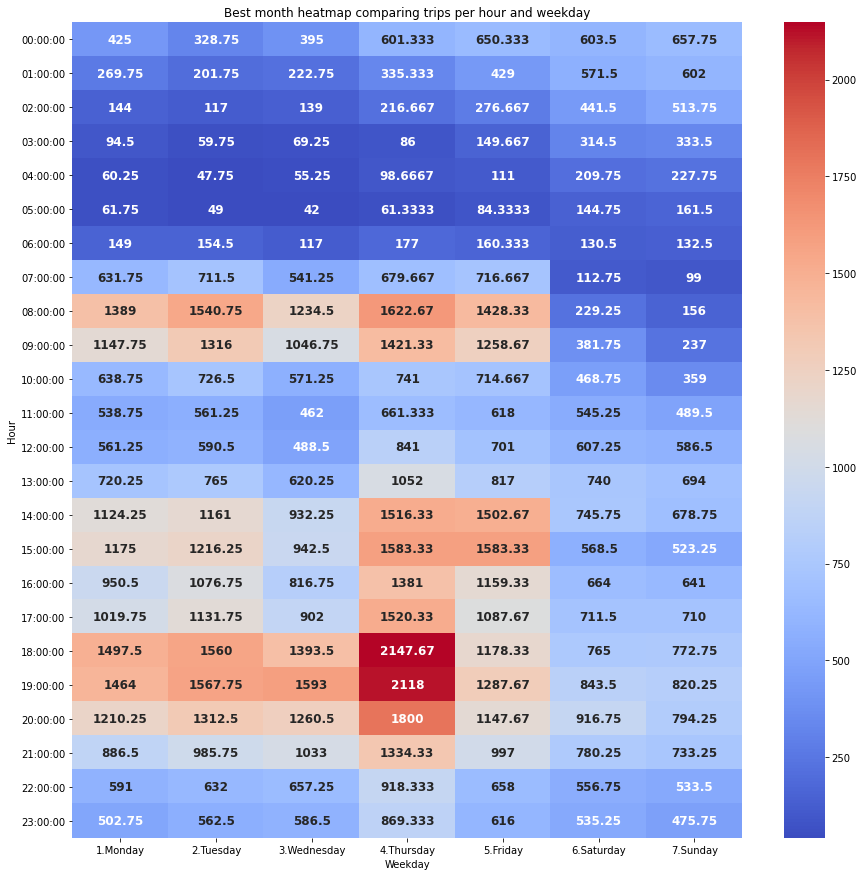

In [ ]:
plt.figure(figsize=(15,15))
heatmap_trips_b = pd.pivot_table(panda_b, values = 'Trips Average', index=['Hour'], columns='Weekday')
sns.heatmap(heatmap_trips_b, cmap='coolwarm', annot=True, fmt='g',  annot_kws={"fontsize":12, 'weight':'bold'})
plt.title("Best month heatmap comparing trips per hour and weekday")
show()

En esta gráfica queda recogida la información referente al mes de Junio de 2019, el mes en el que más trayectos se produjeron del período seleccionado.

Durante los días de entre semana, podemos distinguir las siguientes franjas;:


*   Entre las 07:00 y las 9:59, horas en las que los ciudadanos se dirigen a sus puestos de trabajo, observamos que, entre las 07:00 y las 07:59, los viajes se mantienen entre los 541 y los 716, para, en las horas siguientes despuntar superando todos los días los 1000. Particularmente transitado es el tramos entre las 08:00 y las 08:59.

*   Durante la mañana (10:00-13:59), los viajes descienden debido al menor tránsito de trabajadores.

*   Entre las 14:00 y las 15:59 los viajes vuelven a subir hasta medidas similares obtenidas en el primer tramo considerado. 

*   Durante el primer tramo de la trade (16:00- 17:59) los viajes descienden un poco con respecto al tramo entre las 14:00 y las 15:59, pero, más tarde, entre las 18:00 y las 20:59, se alcanzan los máximos diarios. Los jueves los viajes suben hasta los 2118 y, en el resto de días, superan holgadamente los 1200 trayectos. 

*   Durante la noche, podemos diferenciar el tramo comprendido entre las 21:00 y las 23:59 y el comprendido entre las 00:00 y las 06:59. En el primero, los viajes comienzan a decrecer pero se mantienen superando los 500. En el segundo, se hunden hasta alcanzar los mínimos diarios a las 05:00.

Los fines de semana observamos un claro estancamiento de los viajes, pues nunca superan los 1000. Hay poca variación según la hora: las horas puntas desaparecen y las diferencias no son muy marcadas.

Si bien, durante los fines de semana, el uso nocturno de las bicis es bastante mayor por motivos obvios. En el primer tramo de la noche, el número de viajes es similar, pero, conforme avanaza la madrugada, su uso aumenta con respecto a los días de entre semana.

Hagamos una comparativa entre el peor y el mejor mes.
Para ello, fusionaremos los anteriores heatmaps en uno único.

Veremos cuál ha sido la pérdida (o ganancia) de viajes en el peor mes respecto del mejor mes.

Para un determinado día en una determinada hora, en el mejor mes hay x viajes y en el peor mes hay y viajes, el heatmap muestra y-x.


Por ejemplo, si en el mejor mes hay 10 viajes y en el peor 7, aparecerá -3, pues ha habido una pérdida de 3 viajes. Por el contrario, si en el mejor mes hay 7 viajes y en el peor 10, aparecerá 3, pues se han aumentado 3 viajes.

In [ ]:
panda_comparison = pd.merge(panda_b, panda_w, on=["Weekday", "Hour"]) 
difference_column = panda_comparison["Trips Average_y"] - panda_comparison["Trips Average_x"]
panda_comparison["Difference"] = difference_column

In [ ]:
minimum = panda_comparison["Difference"].min()
maximum = panda_comparison["Difference"].max()

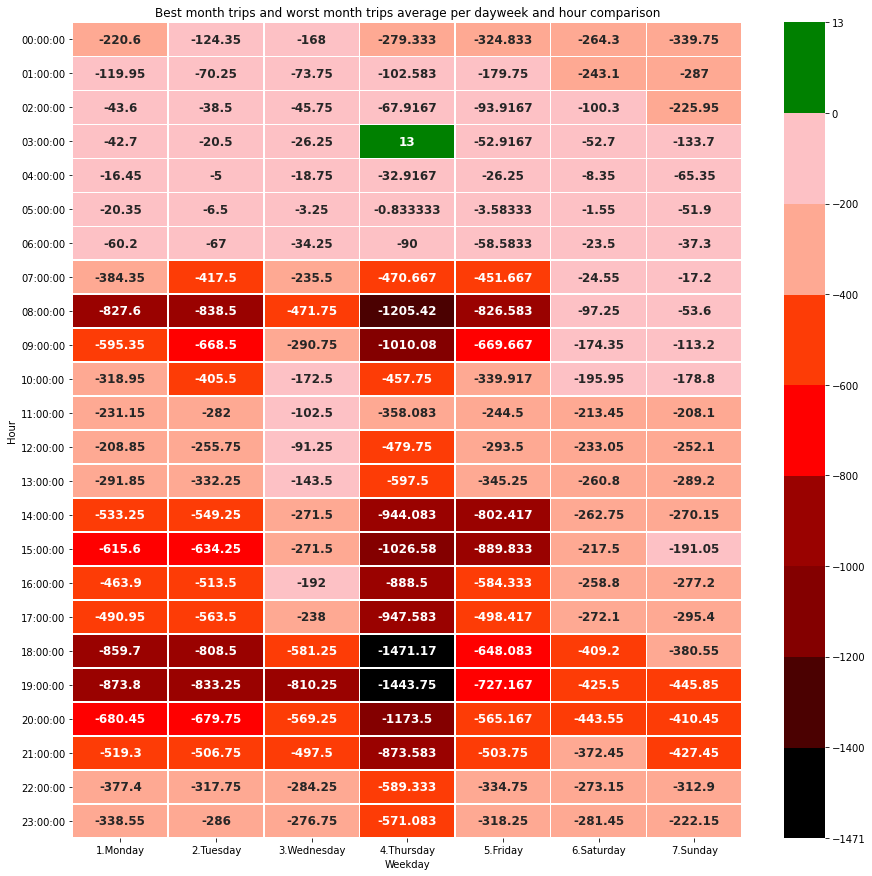

In [ ]:
cmap = colors.ListedColormap(['black', '#4b0101', '#840000', '#9a0200',  'red', '#fd3c06', '#fea993', '#fdc1c5', 'green'])
bounds = [minimum, -1400, -1200, -1000, -800, - 600, -400, -200, 0, maximum]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(15,15))
heatmap_trips_b = pd.pivot_table(panda_comparison, values = 'Difference', index=['Hour'], columns='Weekday')
sns.heatmap(heatmap_trips_b, cmap = cmap, norm = norm, annot=True, fmt='g', annot_kws={"fontsize":12, 'weight':'bold'}, linewidths=.5)
plt.title("Best month trips and worst month trips average per dayweek and hour comparison") 
plt.show()

Observamos que sólo se produce un incremento a las 03:00 de únicamente 13 viajes, lo cual parece anecdótico. La tónica general es la disminución de viajes. 


En primer lugar, nos limitamos a observar qué ocurre de lunes a viernes.A 
grosso modo, podemos diferenciar varias franjas horarias:


*   Entre la 00:59 y las 6:59, la perdida de viajes bascula entre 0 y 200, salvo por la excepción que ocurre los jueves a las 03:00, que podríamos considerar anecdótica. La disminución de viajes en mínima, pues no alcanza la decena en muchas ocasiones, por ejemplo los martes. 
*    Más tarde, entre las 07:00 y las 09:59, hora de entrada a los puestos de trabajo (los centros educativos en junio y diciembre o están en su mayoría cerrados o la asistencia en bici a ellos es despreciable), se observa un claro repunte en las pérdidas. De media, se pierden 634.09 viajes. Las pérdidas se acentúan entre las 08:00 y las 09:00, pues en la mayoría de dias supera los 800 trayectos, llegando a alcanzar los 1205. 
*   Entre las 10:00 y las 13:59, la pérdida es más moderada, pues, en general se mantiene en el rango de 200 a 400 trayectos. 
*   Durante la tarde, entre las 14:00 y las 21:59, las pérdidas vuelven a acentuarse, alcanzando valores extraordinarios entre las 17:59 y las 19:59. Las mayores pérdidas se producen los jueves a esta hora, superando las 1400.
*   Posteriormente, entre las 22:00 y las 00:59, las pérdidas rondan entre las 200 y 400, produciéndose un descenso similar observado entre las 10:00 y las 13:59


En los fines de semana, por el contrario, podemos limitarnos a cuatro franjas.
*   Entre las 02:00 y las 08:59 las pérdidas se mantienen entre 0-200, 
creciendo según avanza la mañana.
*   Entre las 09:00 y las 17:59, las pérdidas rondan las 200.
*  Entre las 18:00 y las 21:59, las pérdidas se mantienen en unas 400, asemejándose, aunque quedando por debajo, a las obtenidas los días de diario.
*   Entre las 22.00 y las 01:59, las pérdidas vuelven a mantenerse entre 200-400.


## **Versión alternativa**



Esta sección fue elaborada por dos integrantes del grupo. Como era de esperar, cada persona diseñó una manera distinta de tratar los datos, si bien, se obtuvieron los mismos resultados en ambas versiones. Adjuntamos el código de la otra versión comentado, para que sea ejecutado si se desea. Adjuntamos únicamente la parte relativa al mejor mes. 

Actuamos como si estuviésemos en otro cuaderno tras haber obtenido los resultados relativos a la primera parte, por ello nos definimos un nuevo mapper para manipular úúnicamente los datos que nos interesan: la estación de inicio, final el tiempo de viaje y la fecha y hora.

In [ ]:
"""
def mapper_heatmap(line):
  data = json.loads(line)
  start = data['idunplug_station']
  end = data['idplug_station']
  travel_time = data ['travel_time']
  travel_date = data['unplug_hourTime']
  return start, end, travel_time, travel_date
"""

Leemos la rdd de junio de 2019, mejor mes.

In [ ]:
"""
rdd_max_trips = sc.textFile(path+'201906_Usage_Bicimad.json')
"""

Con esta función, se  uenta cuántas veces se repite cada díía de la semana en un periodeo de tiempo determinado.

In [ ]:
"""
from collections import Counter
import datetime

def dates_between(start, end):
    while start <= end:
        yield start
        start += datetime.timedelta(1)

def count_weekday(start, end):
    counter = Counter()
    for date in dates_between(start, end):
        counter[date.strftime('%a')] += 1
    return counter

repetitions = dict(count_weekday(datetime.date(2019,6,1), datetime.date(2019,6,26)))
"""

Tras leer la rdd, aplicamos el mapper. Fltramos los viajes por aquellos que duran más de 30 segundos y sus estaciones de origen y destino son distintas. Dada la fecha en formato ISO 8601 en la componente x[3] devuelta por el mapper, leemos el diccionario que nos proporcina el dataset y, mediante parse, leemos el formato ISO 8601. Mapeamos una funcióón que nos devuelve tuplas de la forma ((dia_de_semana, hora),1) Agrupamos segúún claves, y creamos una lista para los valores Mapeamos para conseguir una tupla final de la forma (dia_de_semana, hora, media_de_viajes_por_dia_y_hora). Para elo, tenemos en cuenta cuáántas veces se repite ese dia en el periodo deseado.

Este formato de salida no es casual, pues será esencial a la hora de definir el objeto de tipo 'panda' que nos facilitará la creación del 'heatmap'


In [ ]:
"""
rdd_max_travel_date = rdd_max_trips.map(mapper_heatmap).\
                      filter(lambda x: x[0] != x[1] and x[2] > 30).\
                      map(lambda x: parse(x[3]['$date'])).\
                      map(lambda x: ((x.date().strftime('%a'), x.time().strftime('%H:%M:%S')),1)).\
                      groupByKey().map(lambda x: (x[0], list(x[1]))).\
                      map(lambda x: (x[0][0], x[0][1], sum(x[1])/repetitions[x[0][0]]))
"""

Como paso intermedio, convertimos la rdd en DataFrame, asignando las columnas que ya hemos citado. Convertimos a un objeto panda. Creamos el mapa de calor en el que tomamos como ídice la columna 'Hour' del objeto panda, como columna los días de la semana 'Weekday'. De este modo, los valores que defininen el mapa de calor es la media de viajes por hora y dia de la semana. Por úúlitmo, personalizamos el mapa de calor.


In [ ]:
"""
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

ex = spark.createDataFrame(rdd_max_travel_date, schema = ['Weekday', 'Hour', 'Trips Average'])

panda = ex.toPandas()

plt.figure(figsize=(15,15))
heatmap_trips = pd.pivot_table(panda, values = 'Trips Average', index=['Hour'], columns='Weekday')
sns.heatmap(heatmap_trips, cmap='coolwarm', annot=True, fmt='g',  annot_kws={"fontsize":12, 'weight':'bold'})
"""